(1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 no

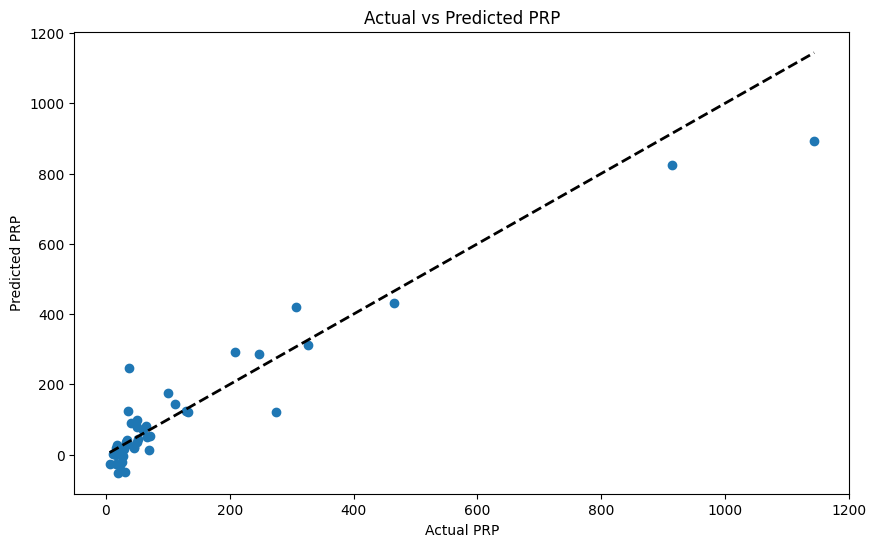

In [12]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# 1. 데이터 탐색 및 시각화
data = pd.read_csv('machine.data_update.csv')
print(data.head())
print(data.info())

# 2. 데이터 전처리
numeric_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
categorical_features = ['VendorName', 'ModelName']

# OneHotEncoder에 unknown 범주 처리 추가
encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', encoder, categorical_features)
    ])

# 3. 훈련/테스트 데이터 분리
X = data.drop(['PRP', 'ERP'], axis=1)
y = data['PRP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 파이프라인 구축 및 하이퍼파라미터 튜닝
reg = LinearRegression()
pipeline = Pipeline([('preprocess', preprocessor), ('model', reg)])

param_grid = {
    'model__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 5. 최적 모델 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2_score = grid_search.best_score_

print(f"Best R-squared score: {r2_score:.2f}")

# 6. 분석 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs Predicted PRP')
plt.show()


(2) (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
- Mean squared Error, Mean absolute Error, R^2, 교차검증

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# 4. 파이프라인 구축 및 하이퍼파라미터 튜닝
reg = LinearRegression()
pipeline = Pipeline([('preprocess', preprocessor), ('model', reg)])

param_grid = {
    'model__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 5. 최적 모델 평가
best_model = grid_search.best_estimator_

# 학습 데이터 평가
y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2').mean()

print("Training Set Performance:")
print(f"Mean Squared Error: {mse_train:.2f}")
print(f"Mean Absolute Error: {mae_train:.2f}")
print(f"R-squared: {r2_train:.2f}")
print(f"Cross-Validation R-squared: {cv_score:.2f}")

# 테스트 데이터 평가
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest Set Performance:")
print(f"Mean Squared Error: {mse_test:.2f}")
print(f"Mean Absolute Error: {mae_test:.2f}")
print(f"R-squared: {r2_test:.2f}")


Training Set Performance:
Mean Squared Error: 0.00
Mean Absolute Error: 0.00
R-squared: 1.00
Cross-Validation R-squared: 0.61

Test Set Performance:
Mean Squared Error: 4988.54
Mean Absolute Error: 46.65
R-squared: 0.90


(3) (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.

In [14]:
y_test_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print(f"Test Set R-squared: {r2_test:.2f}")


Test Set R-squared: 0.90


(4) I. 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.

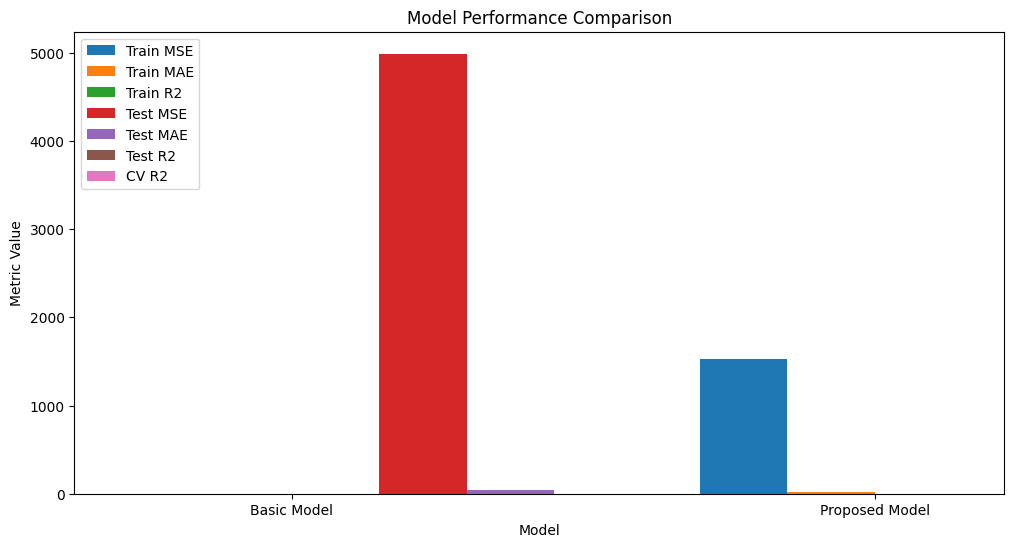

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 성능 지표 데이터 준비
data = {
    'Model': ['Basic Model', 'Proposed Model'],
    'Train MSE': [0.00, 1524.00],
    'Train MAE': [0.00, 23.31], 
    'Train R2': [1.00, 0.92],
    'CV R2': [0.61, np.nan],
    'Test MSE': [4988.54, np.nan],
    'Test MAE': [46.65, np.nan],
    'Test R2': [0.90, np.nan]
}

df = pd.DataFrame(data)

# 바 차트 생성
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df))  # x 축 위치 설정
width = 0.15  # 막대 너비 설정

# 각각의 성능 지표에 대해 막대 차트 생성
ax.bar(x - 3*width/2, df['Train MSE'], width, label='Train MSE')
ax.bar(x - width/2, df['Train MAE'], width, label='Train MAE')
ax.bar(x + width/2, df['Train R2'], width, label='Train R2')
ax.bar(x + 3*width/2, df['Test MSE'], width, label='Test MSE')
ax.bar(x + 5*width/2, df['Test MAE'], width, label='Test MAE')
ax.bar(x + 7*width/2, df['Test R2'], width, label='Test R2')
ax.bar(x + 9*width/2, df['CV R2'], width, label='CV R2')

# x 축 설정
ax.set_xticks(x)
ax.set_xticklabels(df['Model'])

# 범례 표시
ax.legend()

# 차트 제목 및 축 이름 설정
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Metric Value')

# 차트 출력
plt.show()


(5) (1), (2), (3), (4) 단계 전 과정을 포함한 전체 프로그래밍을 소스파일 “pipeline_cpu_data.ipynb”로 작성해서 사이버캠퍼스 “4차 프로그래밍과제”와 github에 각각 업로드 하시오.